In [7]:
%matplotlib inline

import sys
sys.path.append("..")
import splitwavepy as sw

import scipy
import numpy as np
import matplotlib.pyplot as plt

In [8]:
def get_noise(y):
    """
    Return a randomly simulated noise trace with similar spectral properties to y.
    """  
    # white noise
    x = np.random.normal(0,1,y.size)
    # convolve with y
    x = np.convolve(x,y,'same')
    # additional randomisation
    x = np.roll(x,np.random.randint(y.size))
    # whipeout near nyquist
    x = np.convolve(np.array([1,1,1]),x,'same')
    # normalise energy
    x = x * np.sqrt((np.sum(y**2) / np.sum(x**2)))
    # return
    return x


In [9]:
def bootstrap_sample(data,fast,lag):    
    # copy original data
    bs = data.copy()   
    origang = bs.angle
    # replace noise sequence
    bs.unsplit(fast,lag)
    bs.rotateto(bs.pca())
    bs.y = get_noise(bs.y)
    bs.rotateto(origang)
    bs.split(fast,lag)
    return bs

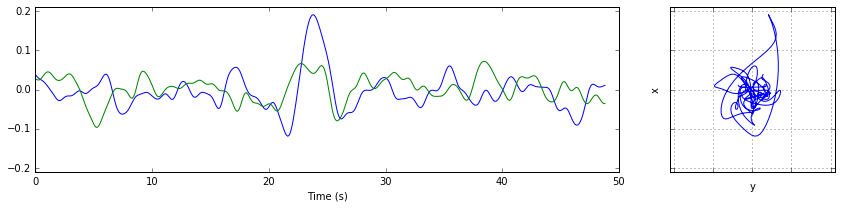

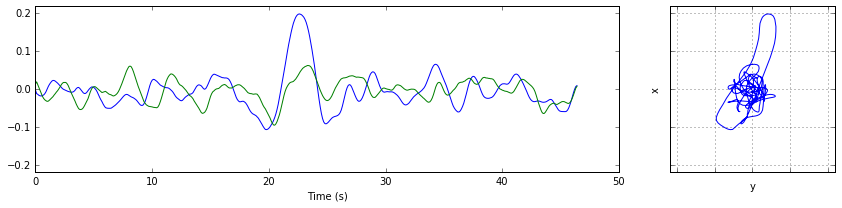

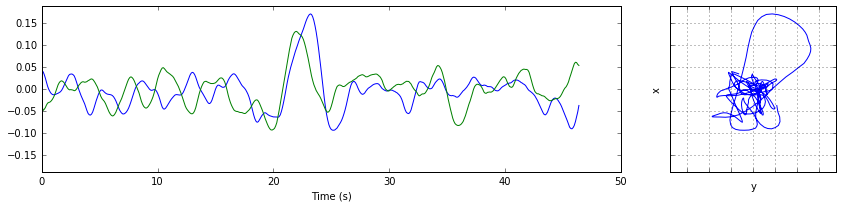

In [106]:
a = sw.Pair(pol=10,delta=0.1,noise=0.1,fast=30,lag=1.2)
a.plot()
b = bootstrap_sample(a,30,1.2)
b.plot()
c = bootstrap_sample(a,30,1.2)
c.plot()

In [186]:
def bootstrap_loop(data,N=50):
    """
    Return list of bootstrap samples
    """        
    # initial measurement:
    m = sw.EigenM(data)
    mlags = m.tlags[:,0]
    mdegs = m.degs[0,:]
    # get probability surface to pick from
    # boost surf by **3 to enhance picks at peaks (value chosen by testing on synthetics)
    surf = (m.lam1/m.lam2)**3
    dlag = m.lags[1,0] - m.lags[0,0]
    density = rho(m.lags,dlag)
    surf = surf / density
    surf = surf / surf.sum()
    
    # pick fast and tlag from surf
    probs = surf.ravel()
    picks = np.random.choice(probs.size,size=N,replace=True,p=probs)
    idx = np.unravel_index(picks,surf.shape)
    
    # generate bootstrap sample measurements    
    bslist = [ sw.EigenM(bs,tlags=mlags,degs=mdegs) for bs in [ bootstrap_sample(data,degs,lags) for lags,degs in zip(m.tlags[idx],m.degs[idx]) ] ]
    return bslist

In [108]:
def rho(n,step):
    if n == 0:
        return 1 / (np.pi/4 * step**2)
    elif n > 0:
        return 1 / (2 * np.pi * n * step)
    else:
        raise Exception('n not valid')
        
rho = np.vectorize(rho)

In [109]:
m = sw.EigenM(a)

/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


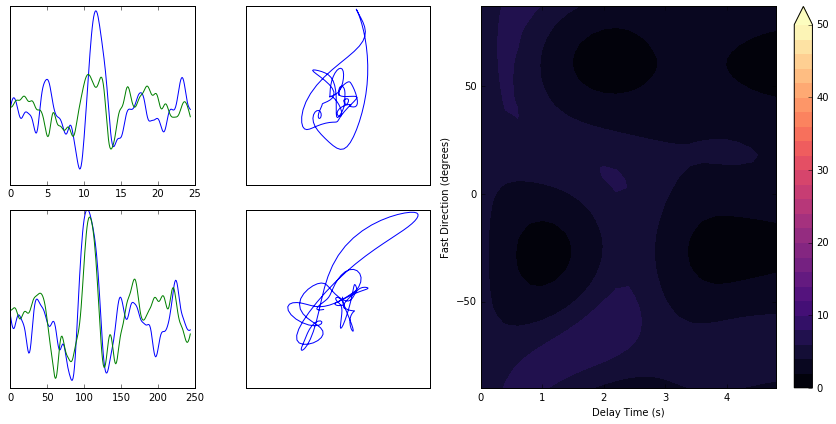

In [110]:
m.plot()

In [111]:
m.fast

-66

In [112]:
surf = (m.lam1/m.lam2)**3
dlag = m.lags[1,0] - m.lags[0,0]
density = rho(m.lags,dlag)
surf = surf/density
surf = surf / surf.sum()

/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


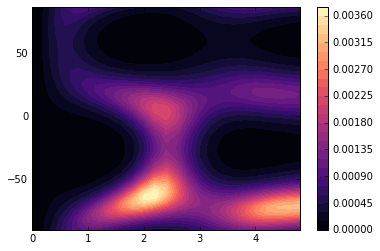

In [113]:
plt.contourf(m.tlags,m.degs,surf,26,cmap='magma')
plt.colorbar()

In [124]:
probs = surf.ravel()
picks = np.random.choice(probs.size,size=50,replace=True,p=probs)
idx = np.unravel_index(picks,surf.shape)

/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


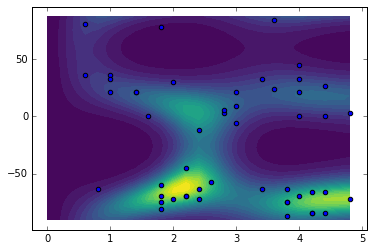

In [126]:
plt.contourf(m.tlags,m.degs,surf,26,cmap='viridis')
plt.scatter(m.tlags[idx],m.degs[idx])

In [127]:
m.degs[idx]
m.tlags[idx]

array([ 3.8,  0.6,  0.6,  4.4,  4.4,  2.6,  4. ,  3.4,  4.4,  1.8,  4.2,
        4.2,  3. ,  4.8,  0.8,  2.2,  4. ,  4. ,  2.8,  4.2,  1.4,  1.8,
        2. ,  1.6,  1. ,  2.4,  2. ,  2.2,  2.2,  3.8,  2.8,  1.8,  4. ,
        3.8,  1. ,  3.8,  4. ,  3.6,  1.8,  2.4,  3. ,  3.4,  1.8,  3. ,
        4.8,  1.4,  2.4,  1. ,  3.6,  4.4])

In [187]:
l = bootstrap_loop(a)

In [188]:
v = [ m.lam1 / m.lam2 for m in l ]
stk = np.stack(v)

/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


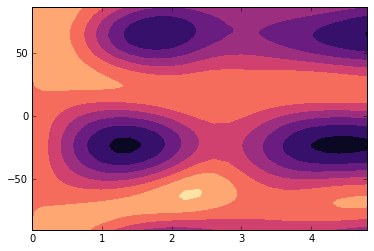

In [193]:
plt.contourf(m.tlags,m.degs,stk.sum(axis=0),cmap='magma')

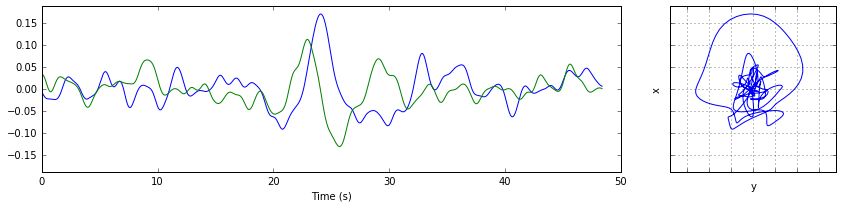

In [200]:
a = sw.Pair(delta=0.1,fast=30,lag=1.5,noise=0.1)
a.plot()

/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


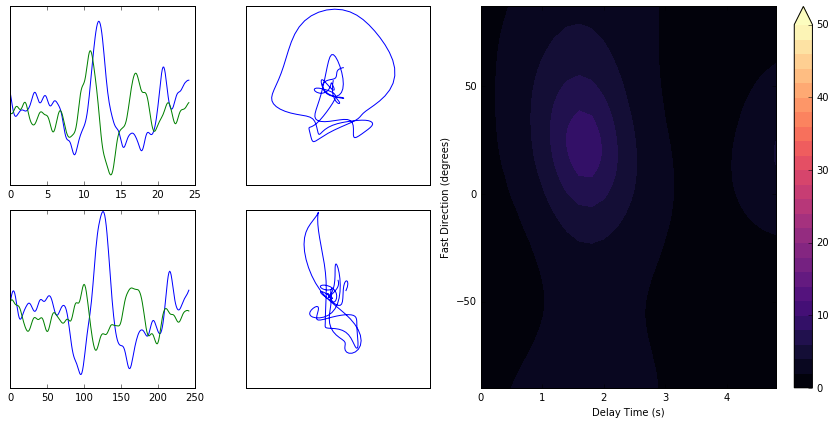

In [201]:
m = sw.EigenM(a)
m.plot()

In [204]:
bs = bootstrap_loop(a,N=100)

/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/Users/glyjw/anaconda/envs/py35/lib/python3.5/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


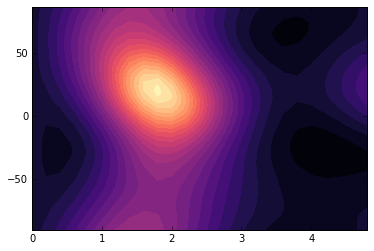

In [205]:
v = [ m.lam1 / m.lam2 for m in bs ]
stk = np.stack(v)
plt.contourf(m.tlags,m.degs,stk.sum(axis=0),26,cmap='magma')

In [213]:
phis = [ m.fast for m in bs ]
lags = [ m.tlag for m in bs ]

In [214]:
circstd = scipy.stats.circstd(2*np.deg2rad(phis))
print(0.5 * np.rad2deg(circstd))

lagstd = np.std(lags)
print(lagstd)

30.1629644505
0.779935894802
